# 은행 이탈 유저 예측 모델 개발

2024.01.13 ~ 2024.01.21

---

## 1. 프로젝트 개요

### 1-1. 프로젝트 요약
- 제목: 은행 이탈 유저 예측 모델 개발
- 설명: 유저가 계좌 이용을 계속할지, 혹은 해지할지를 예측하는 이진 분류 Kaggle Competition
- 사용한 데이터셋
    - [Binary Classification with a Bank Churn Dataset(Playground Series - Season 4, Episode 1)](https://www.kaggle.com/competitions/playground-series-s4e1)
- 진행 절차 및 내용
    - 컬럼별 EDA, 특성에 맞는 **전처리 및 스케일링**
    - **분류 모델** 비교, 적합한 모델 선정, 하이퍼파라미터 튜닝
    - Kaggle Competition 제출
- 사용한 스킬셋
    - pandas
    - matplotlib, seaborn
    - scikit-learn

### 1-2. 프로젝트 진행 배경

모든 서비스 제공자들의 주요 목표는 활성화 고객을 유지하고, 이탈 유저를 붙잡아 두는 것이다. 그렇기 때문에 서비스단에서 중요하게 생각하는 KPI 중 하나가 유저 이탈율이다. 유저가 서비스를 해지하거나 더 이상 이용하지 않으려는 이유를 파악하고, 방지 대책을 강구하는 과정이 꽤 중요하게 간주된다. 이 과정에서 머신러닝 방법론을 통해 이탈 유저를 예측할 수 있다면, 그들을 붙잡아 둘 수 있는 여러 플레이들을 고안해 낼 수 있을 것이다.

본 프로젝트에서는 은행 서비스를 이용하는 고객들에 대한 여러 요인이 포함된 데이터를 이용하여, 유저의 이탈을 예측하는 머신러닝 프로젝트를 수행한다.

---

## 2. 데이터 로딩 및 EDA

### 2-1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [22]:
bank_df = pd.read_csv('train.csv')
bank_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [23]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [24]:
bank_df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

결측치 없이 매끈하게 가공되어 있는 데이터다.

본격적인 EDA에 앞서 컬럼별 분포 보면서 데이터 모양새 살펴본다.

In [128]:
bank_df.corr()

C:\Users\louis\AppData\Local\Temp\ipykernel_9804\2453432335.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  bank_df.corr()


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,1.000000,-0.000387,-0.001201,0.004039,-0.002560,0.000606,-0.000094,-0.004706,0.000418,-0.001552,0.002512
CustomerId,-0.000387,1.000000,0.007364,0.002696,-0.001252,-0.008348,0.004380,-0.005469,-0.002934,0.002891,-0.009947
CreditScore,-0.001201,0.007364,1.000000,-0.008918,0.000942,0.006973,0.011361,-0.002828,0.014790,-0.001820,-0.027383
Age,0.004039,0.002696,-0.008918,1.000000,-0.010830,0.064318,-0.102195,-0.012111,0.003320,-0.005399,0.340768
Tenure,-0.002560,-0.001252,0.000942,-0.010830,1.000000,-0.009481,0.007335,0.005327,-0.005532,0.000971,-0.019565
Balance,0.000606,-0.008348,0.006973,0.064318,-0.009481,1.000000,-0.361033,-0.018584,-0.015073,0.008586,0.129743
NumOfProducts,-0.000094,0.004380,0.011361,-0.102195,0.007335,-0.361033,1.000000,0.005482,0.039736,-0.004285,-0.214554
HasCrCard,-0.004706,-0.005469,-0.002828,-0.012111,0.005327,-0.018584,0.005482,1.000000,-0.021034,0.004438,-0.022141
IsActiveMember,0.000418,-0.002934,0.014790,0.003320,-0.005532,-0.015073,0.039736,-0.021034,1.000000,-0.008080,-0.210237
EstimatedSalary,-0.001552,0.002891,-0.001820,-0.005399,0.000971,0.008586,-0.004285,0.004438,-0.008080,1.000000,0.018827


모델 만들 때 상관관계가 너무 높으면 다중공선성 문제가 발생할 수 있기 때문에 corr 0.5 이상인 경우 유의해서 봐줘야 한다.

C:\Users\louis\AppData\Local\Temp\ipykernel_9804\3108468010.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = np.abs(bank_df.corr())


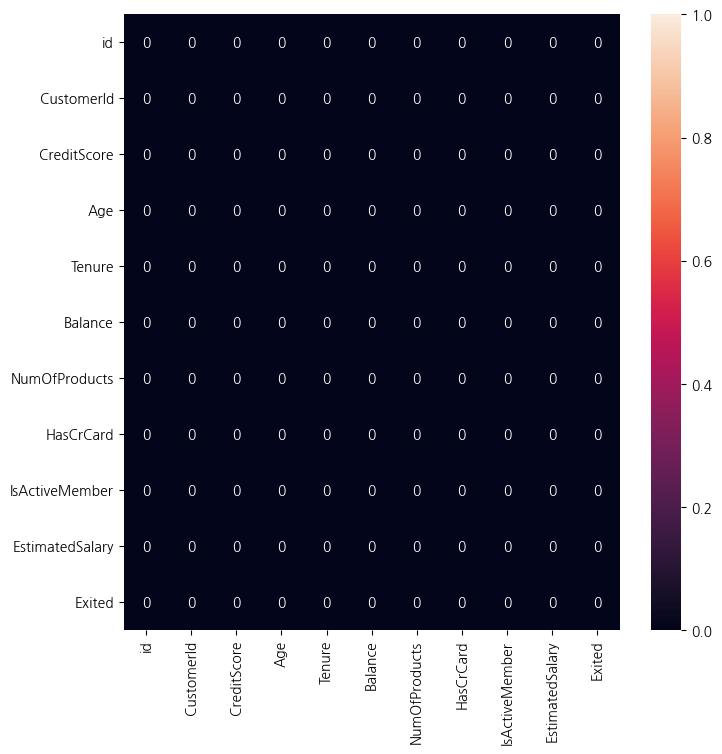

In [143]:
corr_df = np.abs(bank_df.corr())

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_df[(corr_df >= 0.5) & (corr_df < 1)].fillna(0),
    vmin=0,
    vmax=1,
    annot=True
)
plt.show()

단 하나도 없구나...

C:\Users\louis\AppData\Local\Temp\ipykernel_9804\2769644401.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = np.abs(bank_df.corr())


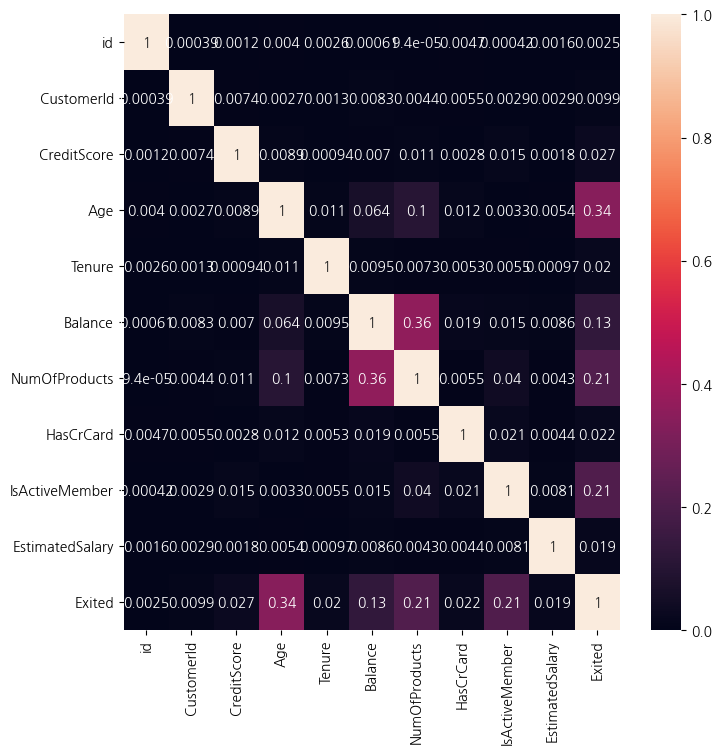

In [145]:
corr_df = np.abs(bank_df.corr())

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_df,
    vmin=0,
    vmax=1,
    annot=True
)
plt.show()

### 2-2. 데이터 분포 확인 및 전처리

#### 2-2-1. 필요없는 데이터 제거

우선 필요없어 보이는 컬럼을 제거한다.
- ```id```: ```pd.DataFrame()```에서 자동으로 만들어 주는 인덱스를 쓰면 된다.
- ```CustomerId```, ```Surname```: 딱히 유저 한 명 한 명을 특정하여 식별할 이유가 없는 분석이 될 것이기에 제외한다.

In [34]:
bank_df.drop(['id', 'CustomerId', 'Surname'], axis=1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [36]:
bank_df.drop(['id', 'CustomerId', 'Surname'], axis=1).duplicated().sum()

123

컬럼 몇 개를 덜어내고 나니 놀랍게도 중복된 값이 123개나 있다.

In [37]:
bank_df_dropped = bank_df.drop(['id', 'CustomerId', 'Surname'], axis=1).drop_duplicates()
bank_df_dropped

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


#### 2-2-2. 컬럼별 분포 확인 (신용도)

In [38]:
bank_df_dropped['CreditScore']

0         668
1         627
2         678
3         581
4         716
         ... 
165029    667
165030    792
165031    565
165032    554
165033    850
Name: CreditScore, Length: 164911, dtype: int64

In [39]:
bank_df_dropped['CreditScore'].describe()

count    164911.000000
mean        656.468914
std          80.091065
min         350.000000
25%         597.000000
50%         659.000000
75%         710.000000
max         850.000000
Name: CreditScore, dtype: float64

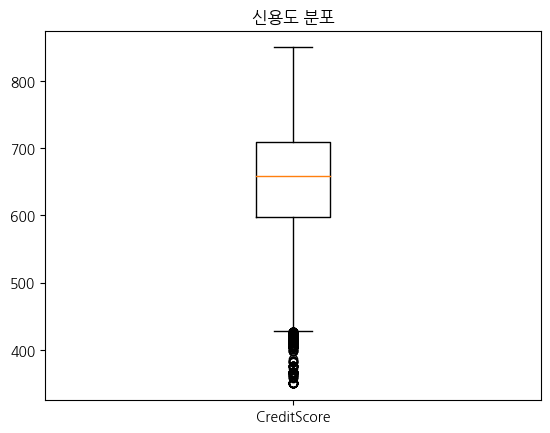

In [120]:
plt.title('신용도 분포')
plt.boxplot(
    bank_df_dropped['CreditScore'],
    labels=['CreditScore']
)
plt.show()

신용도가 일반적인 분포에서 어긋나는 데이터들이 꽤 보인다. 하지만 이탈율 예측에 있어서 이상치들이 꽤 중요하게 작용할 것으로 보인다. 이상치를 제거하거나 정상 범위 끝부분으로 치환 적용하는 경우에 오히려 부정확한 모델 학습이 진행될 여지가 있으므로, 별도의 처리를 해주지 않고 진행한다.

#### 2-2-3. 컬럼별 분포 확인 (국적)

본 데이터에 들어가 있는 인구통계학적 요인은 다음과 같다.
- ```Geography```: 국적
- ```Gender```: 성별
- ```Age```: 나이

이 중 ```Age```를 제외한 두 컬럼은 범주형임에 유의하여 EDA 및 전처리를 진행한다.

In [75]:
bank_df_dropped['Geography']

0         France
1         France
2         France
3         France
4          Spain
           ...  
165029     Spain
165030    France
165031    France
165032     Spain
165033    France
Name: Geography, Length: 164911, dtype: object

In [76]:
bank_df_dropped['Geography'].value_counts()

France     94132
Spain      36192
Germany    34587
Name: Geography, dtype: int64

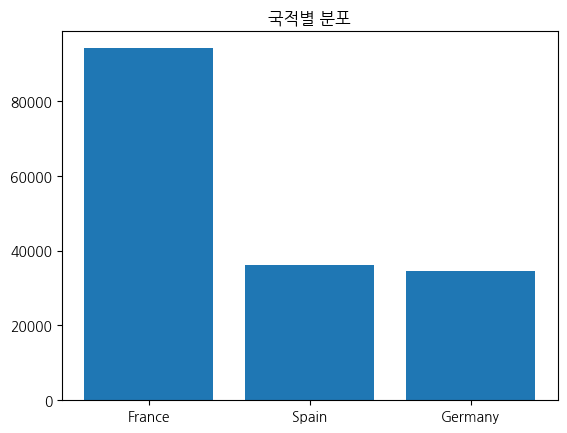

In [121]:
plt.bar(
    bank_df_dropped['Geography'].value_counts().index,
    bank_df_dropped['Geography'].value_counts()
)

plt.title('국적별 분포')
plt.show()

프랑스 유저의 데이터가 가장 많다.

In [85]:
churn_by_geography = bank_df_dropped.groupby('Geography').agg({'Exited': 'sum'})
churn_by_geography['NotExtied'] = bank_df_dropped['Geography'].value_counts() - churn_by_geography['Exited']
churn_by_geography

,Exited,NotExtied
Geography,,
France,15570,78562
Germany,13106,21481
Spain,6233,29959


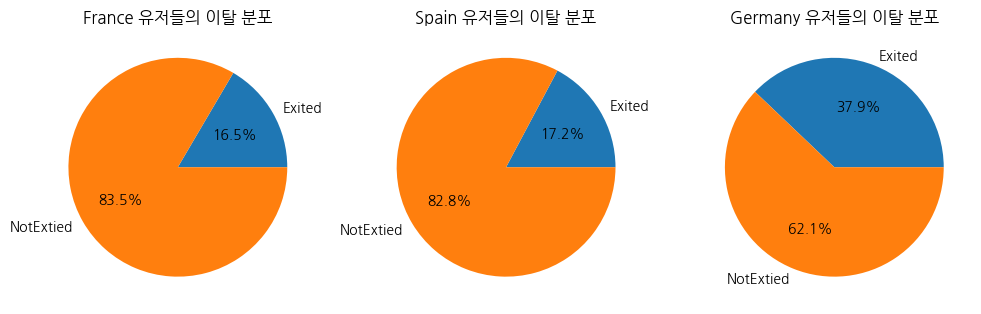

In [122]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
target_data = bank_df_dropped['Geography'].unique()

for i in range(len(target_data)):
    axes[i].pie(
        churn_by_geography.loc[target_data[i]],
        labels=churn_by_geography.loc[target_data[i]].to_frame().index,
        autopct='%.1f%%'
    )
    axes[i].set_title(f'{target_data[i]} 유저들의 이탈 분포')

독일 유저들이 유독 이탈율이 높다.

이탈율이 프랑스 < 스페인 < 독일 순서이므로 이 순서로 Label Encoding을 실시한다.

In [111]:
bank_df_dropped['GeographyNumeric'] = bank_df_dropped['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})

bank_df_dropped[['Geography', 'GeographyNumeric']].value_counts()

Geography  GeographyNumeric
France     0                   94132
Spain      1                   36192
Germany    2                   34587
dtype: int64

제대로 들어갔다.

#### 2-2-4. 컬럼별 분포 확인 (성별)

In [112]:
bank_df_dropped['Gender'].value_counts()

Male      93075
Female    71836
Name: Gender, dtype: int64

In [113]:
churn_by_gender = bank_df_dropped.groupby('Gender').agg({'Exited': 'sum'})
churn_by_gender['NotExtied'] = bank_df_dropped['Gender'].value_counts() - churn_by_gender['Exited']
churn_by_gender

,Exited,NotExtied
Gender,,
Female,20099,51737
Male,14810,78265


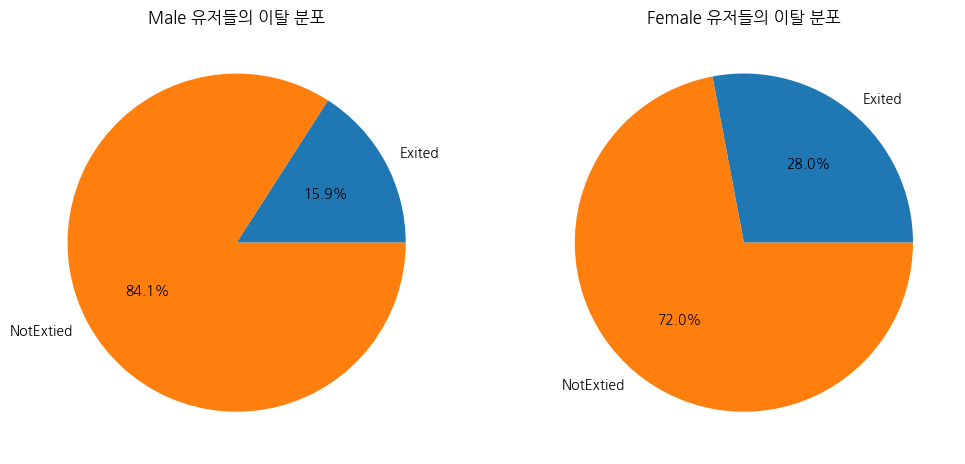

In [123]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
target_data = bank_df_dropped['Gender'].unique()

for i in range(len(target_data)):
    axes[i].pie(
        churn_by_gender.loc[target_data[i]],
        labels=churn_by_gender.loc[target_data[i]].to_frame().index,
        autopct='%.1f%%'
    )
    axes[i].set_title(f'{target_data[i]} 유저들의 이탈 분포')

여자가 남자보다 이탈 비율이 높다.

이탈율이 남자 < 여자 순서이므로 이 순서로 Label Encoding을 실시한다.

In [124]:
bank_df_dropped['GenderNumeric'] = bank_df_dropped['Gender'].map({'Male': 0, 'Female': 1})

bank_df_dropped[['Gender', 'GenderNumeric']].value_counts()

Gender  GenderNumeric
Male    0                93075
Female  1                71836
dtype: int64

#### 2-2-5. 컬럼별 분포 확인 (나이)

In [49]:
bank_df_dropped['Age'].describe()

count    164911.000000
mean         38.124278
std           8.865020
min          18.000000
25%          32.000000
50%          37.000000
75%          42.000000
max          92.000000
Name: Age, dtype: float64

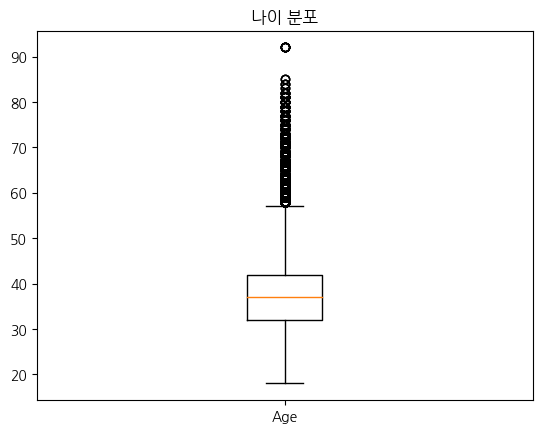

In [125]:
plt.title('나이 분포')
plt.boxplot(
    bank_df_dropped['Age'],
    labels=['Age']
)
plt.show()

나이 컬럼의 경우 높은 값에서의 아웃라이어들이 꽤 많다. 고령의 유저가 이탈율이 높을까?

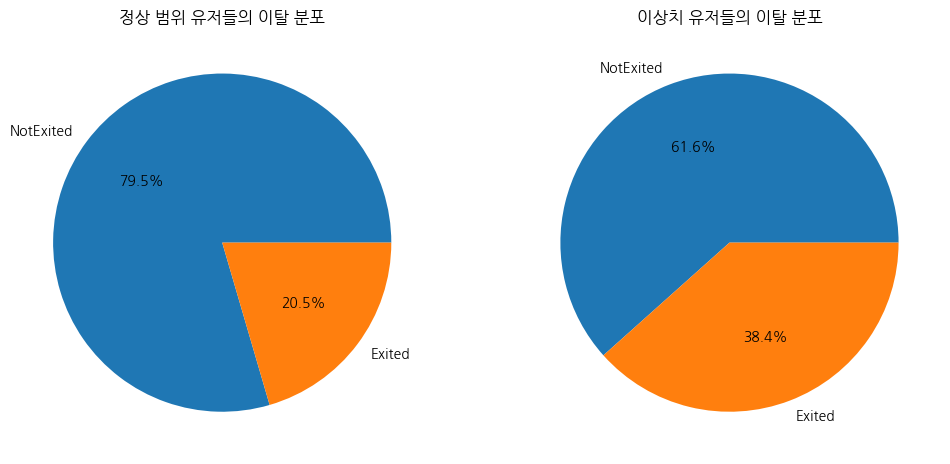

In [126]:
age_Q3 = bank_df_dropped['Age'].describe()['75%']
age_Q1 = bank_df_dropped['Age'].describe()['25%']
age_outlier_threshold = age_Q3 +  1.5 * (age_Q3 - age_Q1)

age_in_range = bank_df_dropped[bank_df_dropped['Age'] <= age_outlier_threshold]['Exited'].value_counts()
age_outlier = bank_df_dropped[bank_df_dropped['Age'] > age_outlier_threshold]['Exited'].value_counts()

fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
target_data = {
    '정상 범위 유저들의 이탈 분포': age_in_range,
    '이상치 유저들의 이탈 분포': age_outlier
}

for i in range(len(target_data.keys())):
    axes[i].pie(
        list(target_data.values())[i].values,
        labels=list(target_data.values())[i].index.map({0: 'NotExited', 1: 'Exited'}),
        autopct='%.1f%%'
    )
    axes[i].set_title(list(target_data.keys())[i])

정상 범위 유저들에 비해, 이상치 유저들의 이탈율이 훨씬 커보인다. 즉, 이상치로 분류되는 값들을 제거했을 때 모델이 정확도 높은 분류를 하기 어려울 것이다. 따라서 이상치에 별도의 처리를 하지 않고 진행한다.

#### 2-2-6. 컬럼별 분포 확인 (유저 이용성)

본 데이터에 들어가 있는 유저 이용 관련 요인들은 다음과 같다.
- ```Tenure```: 보유 계좌 수
- ```Balance```: 계좌 잔고
- ```NumOfProducts```
- ```HasCrCard```: 신용카드 보유 유무
- ```IsActiveMember```: 유저 활동성
- ```EstimatedSalary```

In [127]:
bank_df_dropped[['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']].describe()

,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,164911.000000,164911.000000,164911.000000,164911.000000,164911.000000,164911.000000
mean,5.020599,55481.138955,1.554420,0.753916,0.497693,112579.798396
std,2.806237,62819.233625,0.547171,0.430730,0.499996,50290.229424
min,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,3.000000,0.000000,1.000000,1.000000,0.000000,74639.870000
50%,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000
75%,7.000000,119948.090000,2.000000,1.000000,1.000000,155155.250000
max,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


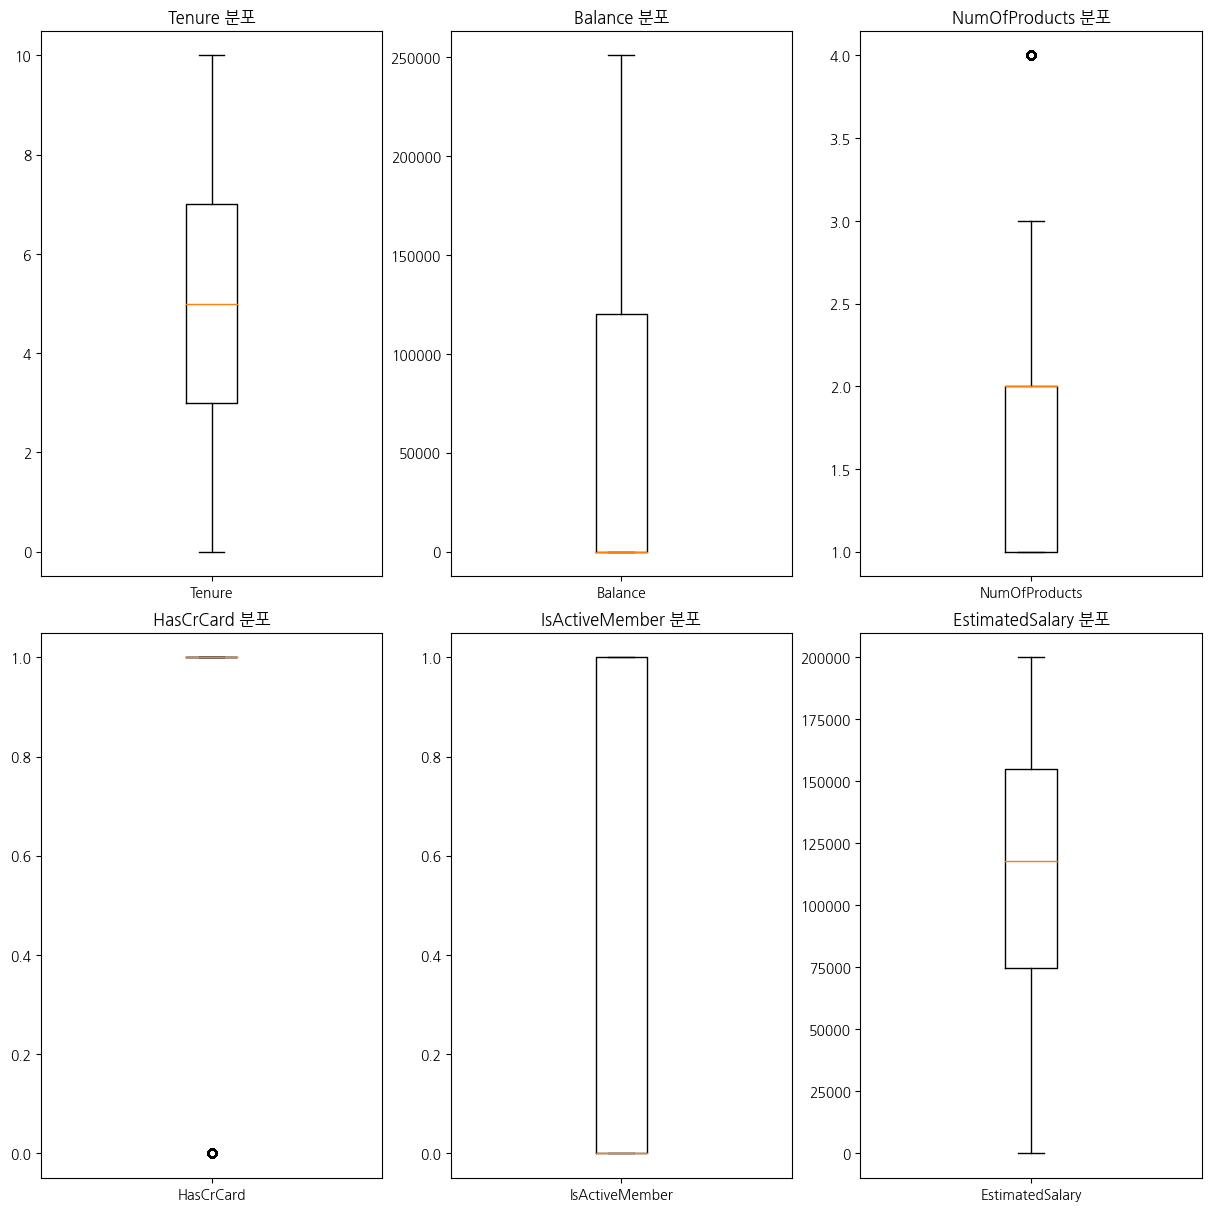

In [155]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12), constrained_layout=True)
target_data = [['Tenure', 'Balance', 'NumOfProducts'], ['HasCrCard', 'IsActiveMember', 'EstimatedSalary']]

for i in range(2):
    for j in range(3):
        axes[i][j].set_title(target_data[i][j] + ' 분포')
        axes[i][j].boxplot(bank_df_dropped[target_data[i][j]], labels=[target_data[i][j]])
        
plt.show()

이상치가 크게 많은 데이터가 없어보이기 때문에 별도의 처리 없이 넘어간다.

#### 2-2-7. 데이터 저장

In [160]:
bank_df_processed = bank_df_dropped.drop(['Geography', 'Gender'], axis=1)
bank_df_processed

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,GeographyNumeric,GenderNumeric
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,1,1
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,0
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,0
165032,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,1,1


In [162]:
with open('bank_df_processed.pkl', 'wb') as file:
    pickle.dump(bank_df_processed, file)

---

## 3. 데이터 분석

### 3-1. 문제 정의

유저가 계좌 이용을 계속할지, 혹은 해지할지를 예측하는 이진 분류 모델을 개발한다.

### 3-2. 데이터 전처리

#### 3-2-1. 데이터 불러오기

In [2]:
with open('bank_df_processed.pkl', 'rb') as file:
    bank_df_processed = pickle.load(file)

In [4]:
bank_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164911 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CreditScore       164911 non-null  int64  
 1   Age               164911 non-null  float64
 2   Tenure            164911 non-null  int64  
 3   Balance           164911 non-null  float64
 4   NumOfProducts     164911 non-null  int64  
 5   HasCrCard         164911 non-null  float64
 6   IsActiveMember    164911 non-null  float64
 7   EstimatedSalary   164911 non-null  float64
 8   Exited            164911 non-null  int64  
 9   GeographyNumeric  164911 non-null  int64  
 10  GenderNumeric     164911 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 15.1 MB


In [3]:
X = bank_df_processed.drop('Exited', axis=1)
y = bank_df_processed['Exited']

X.shape, y.shape

((164911, 10), (164911,))

이전에 피처 엔지니어링은 어느 정도 마쳐놓은 상태다.

#### 3-2-2. 데이터 스케일링

In [4]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X.shape

(164911, 10)

본 데이터에는 0, 1 사이의 이진 데이터들이 다수 존재했던 만큼 MinMaxScaler를 이용한 스케일링이 유리하다고 봤다.

#### 3-2-3. train_test_split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((131928, 10), (32983, 10), (131928,), (32983,))

### 3-3. 분류 모델 생성

#### 3-3-1. 모델 선택

In [10]:
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(tree_method = "hist", device = "cuda"),
    'LightGBM': LGBMClassifier(verbosity=-1, device_type='gpu')
}

model_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    model_results[name] = roc_auc
    print(f"{name} 학습 완료! 성능: {roc_auc}")

LogisticRegression 학습 완료! 성능: 0.8162908669389807
DecisionTree 학습 완료! 성능: 0.7039405839567835
RandomForest 학습 완료! 성능: 0.8737042383547133
XGBoost 학습 완료! 성능: 0.8877248358702375
LightGBM 학습 완료! 성능: 0.8894989809957179


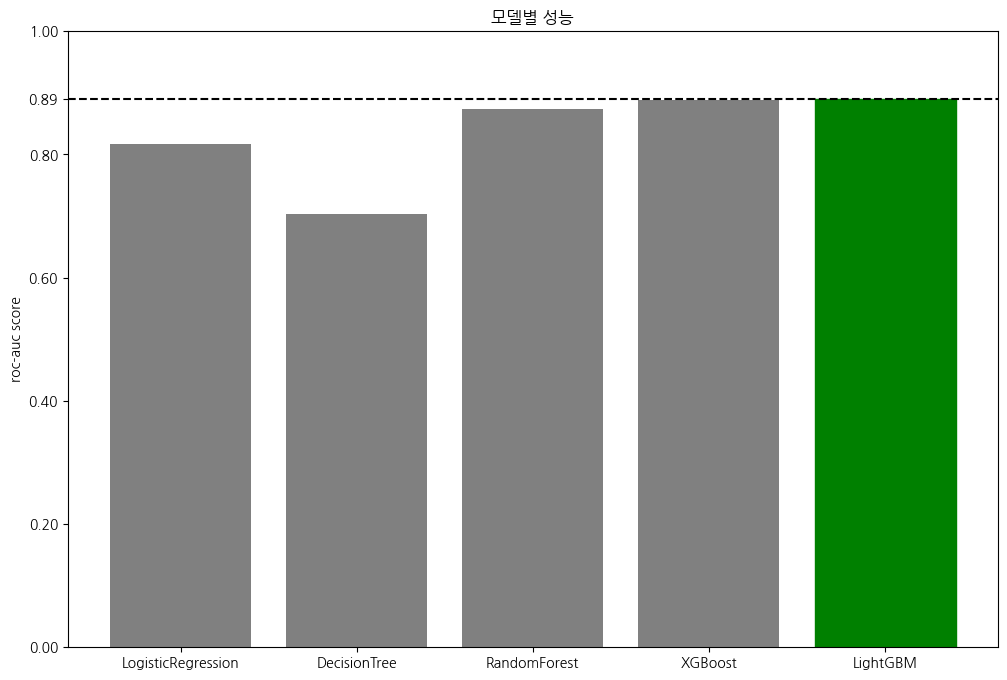

In [13]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    model_results.keys(),
    model_results.values(),
    color='gray'
)

bars[list(model_results.values()).index(max(model_results.values()))].set_color('green')
plt.title('모델별 성능')
plt.ylabel('roc-auc score')
plt.axhline(max(model_results.values()), color='black', linestyle='--')
plt.yticks([0.2 * i for i in range(6)] + [max(model_results.values())])
plt.show()

튜닝하지 않았을 때의 성능이 가장 우월했던 LightGBM을 본 분석에서의 모델로 채택한다.

#### 3-3-2. 하이퍼파라미터 튜닝

In [14]:
model = LGBMClassifier(verbosity=-1, device_type='gpu')

param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [None, 3, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1,  scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [15]:
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f"모델 성능: {roc_auc}")

모델 성능: 0.8897470324032113


#### 3-3-3. test 예측

In [24]:
test_df = pd.read_csv('test.csv')
new_test_df = test_df.copy()
new_test_df['GeographyNumeric'] = test_df['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})
new_test_df['GenderNumeric'] = test_df['Gender'].map({'Male': 0, 'Female': 1})
new_test_df = new_test_df.drop(['id', 'CustomerId', 'Surname', 'Geography', 'Gender'], axis=1)

new_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CreditScore       110023 non-null  int64  
 1   Age               110023 non-null  float64
 2   Tenure            110023 non-null  int64  
 3   Balance           110023 non-null  float64
 4   NumOfProducts     110023 non-null  int64  
 5   HasCrCard         110023 non-null  float64
 6   IsActiveMember    110023 non-null  float64
 7   EstimatedSalary   110023 non-null  float64
 8   GeographyNumeric  110023 non-null  int64  
 9   GenderNumeric     110023 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 8.4 MB


test 데이터에 대해, 앞서 진행했던 전처리를 동일하게 진행해 주었다.

In [26]:
new_X = scaler.fit_transform(new_test_df)
new_y_pred_proba = best_model.predict_proba(new_X)[:, 1]
result = pd.DataFrame()
result['id'] = test_df['id']
result['Exited'] = new_y_pred_proba
result

,id,Exited
0,165034,0.024298
1,165035,0.805654
2,165036,0.029890
3,165037,0.237014
4,165038,0.354490
...,...,...
110018,275052,0.036637
110019,275053,0.108913
110020,275054,0.020661
110021,275055,0.144998


앞서 학습시킨 모델(```best_model```)을 이용하여 예측 확률을 반환해 주었다.

In [28]:
result.to_csv('result.csv', index=False)

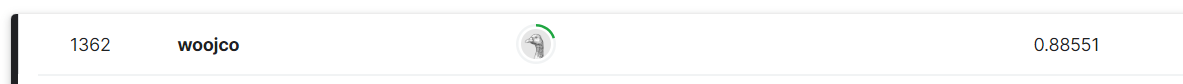

Kaggle에 제출하여 확인한 결과 Public 기준 ROC-AUC Score 0.88551(1362위)이 나왔다. 대다수의 유저들이 89점 언저리에서 놀고 있음을 생각하면, 여기서 추가적인 튜닝을 통해 성능 상승을 꾀한다면 더 높은 순위권으로 들어갈 수 있겠다.

---

## 4. 후기

데이터의 분포를 보면서 어떤 전처리를 진행할지 고민하고, 모델을 선정하고, 학습 및 튜닝을 진행하는 일련의 과정을 모두 수행해 보았다. EDA 과정에서 모델이 이상치에 대해 민감하게 반응해야 할 것이라고 판단했던 만큼 numeric한 변수들에 대해 별도의 이상치 처리는 진행해 주지 않았는데, 이런 판단이 과연 옳았던 건지 자문을 구해보고 싶다.

어느 정도 구색을 갖춘 ML 모델을 생성하는 건 크게 어렵지 않다고 생각한다. 하지만 보다 정밀한 모델을 만드는 건 또 다른 일이다. 지금부터 성능을 깎아나가는 과정이 진짜 고역일 것이다. Public 리더보드 기준으로 1위와 1.6%p밖에 차이가 안 나는데, 그 조금의 격차를 좁히는 게 지금까지의 전 과정보다도 훨씬 많은 노력을 기울여야만 하는 일이 될 것이기 때문이다.

현재는 SQL, 대시보드 위주의 데이터 분석가 포지션을 희망하고 있어서 보다 academic한 부분에 deep dive할 여력이 안 되지만, 추후에는 나 역시 머신러닝 모델을 깎는 장인의 길을 경험해 봐야 할 것이다. 그리 먼 미래가 되진 않을 것이다. 그땐 지금처럼 미니 프로젝트 위주의 스터디가 아닌, 논문 위주의 스터디를 하게 되리라고 생각한다. 